# Usage Example

Suppose we have the problem of computing the square root of the positive difference of two squares,
x and y. The formula is simple: $\sqrt{\left|x^2 - y^2\right|}$. Let's write it in julia:

In [1]:
f(x, y) = sqrt(abs(x^2 - y^2))

f(5, 4)

3.0

So far so good. Now what happens when $x$ and $y$ have almost equal values?

In [2]:
f(3.0 + 1.0e-7, 3.0)

0.0007745966749141229

Compare that with a result in arbitrary precision:

In [3]:
f(big(3.0 + 1.0e-7), big(3.0))

0.0007745966750626113059493756986839639762994675257448567639441517760627581981642562

Clearly, not all of the supposed ca. 15 digits that the `Float64` result carries are correct.
Let's see what `PrecisionCarriers` says:

In [4]:
using PrecisionCarriers
p = f(precify(3.0 + 1.0e-7), precify(3.0))

0.0007745966749141229 <ε=863330>

In [5]:
significant_digits(p)

9.717382970440969

It looks like we lost about 5 significant digits! This happens because of the intermediate
results of $x^2$ and $y^2$ do not carry enough precision to accurately calculate their
difference. This is often called "catastrophic cancellation", because the two values are
almost equal, so many of the most-significant bits are "cancelled".

In this instance, we can resolve the problem for most cases by replacing $x^2 - y^2$
with its binomial representation $(x + y) * (x - y)$. This reduces the instability
of the intermediate values:

In [6]:
f_improved(x, y) = sqrt(abs((x + y) * (x - y)))
p = f_improved(precify(3.0 + 1.0e-7), precify(3.0))

0.0007745966750626113 <ε=0>

In [7]:
significant_digits(p)

16.630646830440586

## Benchmarking

The benchmarking macro `@bench_epsilons` is very helpful to see the precision loss
one can expect from a function at a glance:

In [8]:
@bench_epsilons f(x, y) ranges = begin
    x = (0.0, 5.0)
    y = (0.0, 5.0)
end

  samples:  10000
  minimum:  0 ε
  median:   0.0 ε
  mean:     0.0 ε
  maximum:  0 ε

  no imprecisions > 1000ε found


Compare this with the improved version:

In [9]:
@bench_epsilons f_improved(x, y) ranges = begin
    x = (0.0, 5.0)
    y = (0.0, 5.0)
end

  samples:  10000
  minimum:  0 ε
  median:   0.0 ε
  mean:     0.0 ε
  maximum:  0 ε

  no imprecisions > 1000ε found


For more information on the `@bench_epsilons` macro, please refer to its docstring or the
[tutorial](bench_epsilons.md).

## Plotting

We can also easily visualize the precision loss of either version by plotting the
significant digits on an x-y-plane:

┌ Warning: Module IntervalSetsRandomExt with build ID ffffffff-ffff-ffff-22dc-d480c1c76844 is missing from the cache.
│ This may mean IntervalSetsRandomExt [26d0d72c-3857-57d2-89fc-eff847a63330] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2018
┌ Error: Error during loading of extension IntervalSetsRandomExt of IntervalSets, use `Base.retry_load_extensions()` to retry.
│   exception =
│    1-element ExceptionStack:
│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
│    Stacktrace:
│      [1] _require(pkg::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:2022
│      [2] __require_prelocked(uuidkey::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1882
│      [3] #invoke_in_world#3
│        @ ./essentials.jl:926 [inlined]
│      [4] invoke_in_world
│        @ ./essentials.jl:923 [inlined]
│      [5] _require_prelocked
│        @ ./loading.jl:1873 [inlined]
│      [6] _require_prelocked
│     

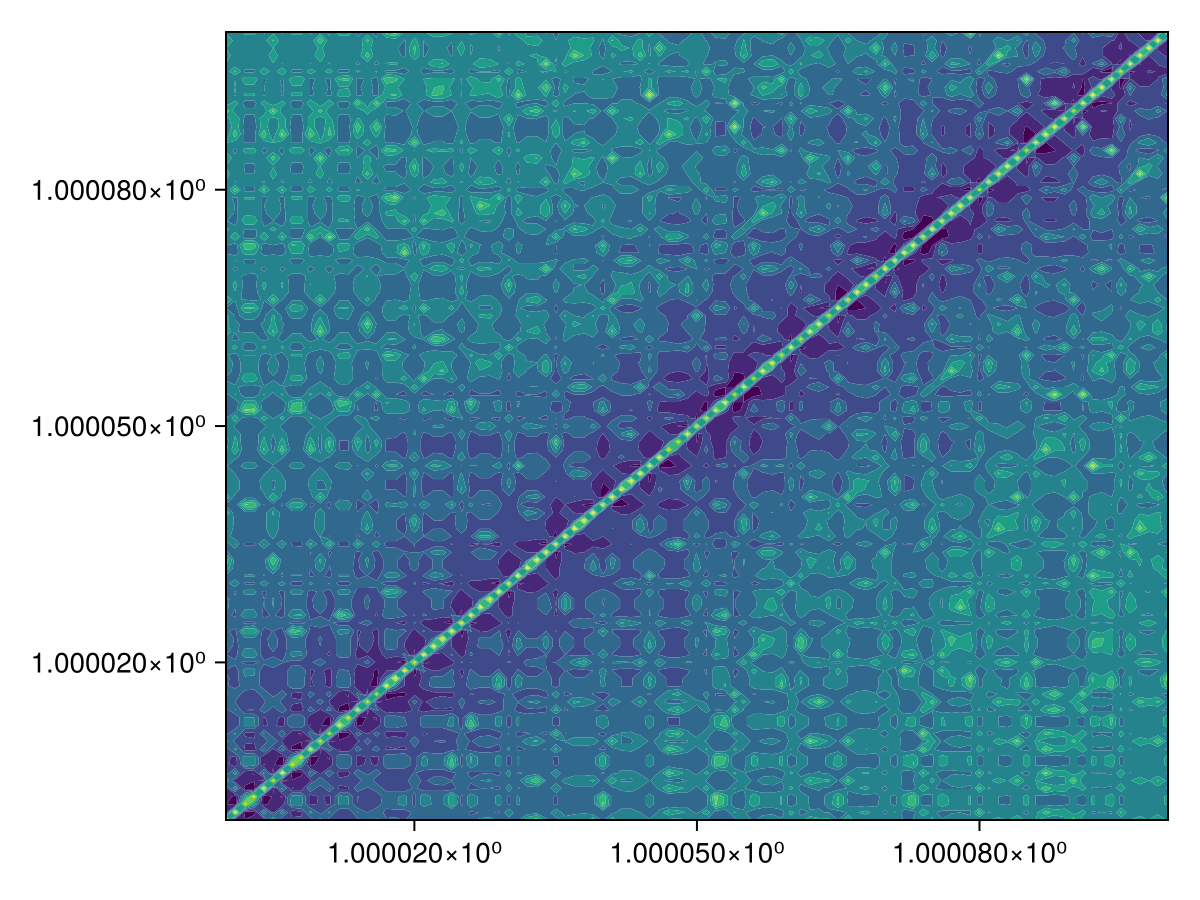

In [10]:
using CairoMakie

x = 1.0:1.0e-6:(1.0 + 1.0e-4)
y = 1.0:1.0e-6:(1.0 + 1.0e-4)

contourf(x, y, (x, y) -> significant_digits(f(precify(x), precify(y))))

With a little more effort we can compare the two versions on some values:

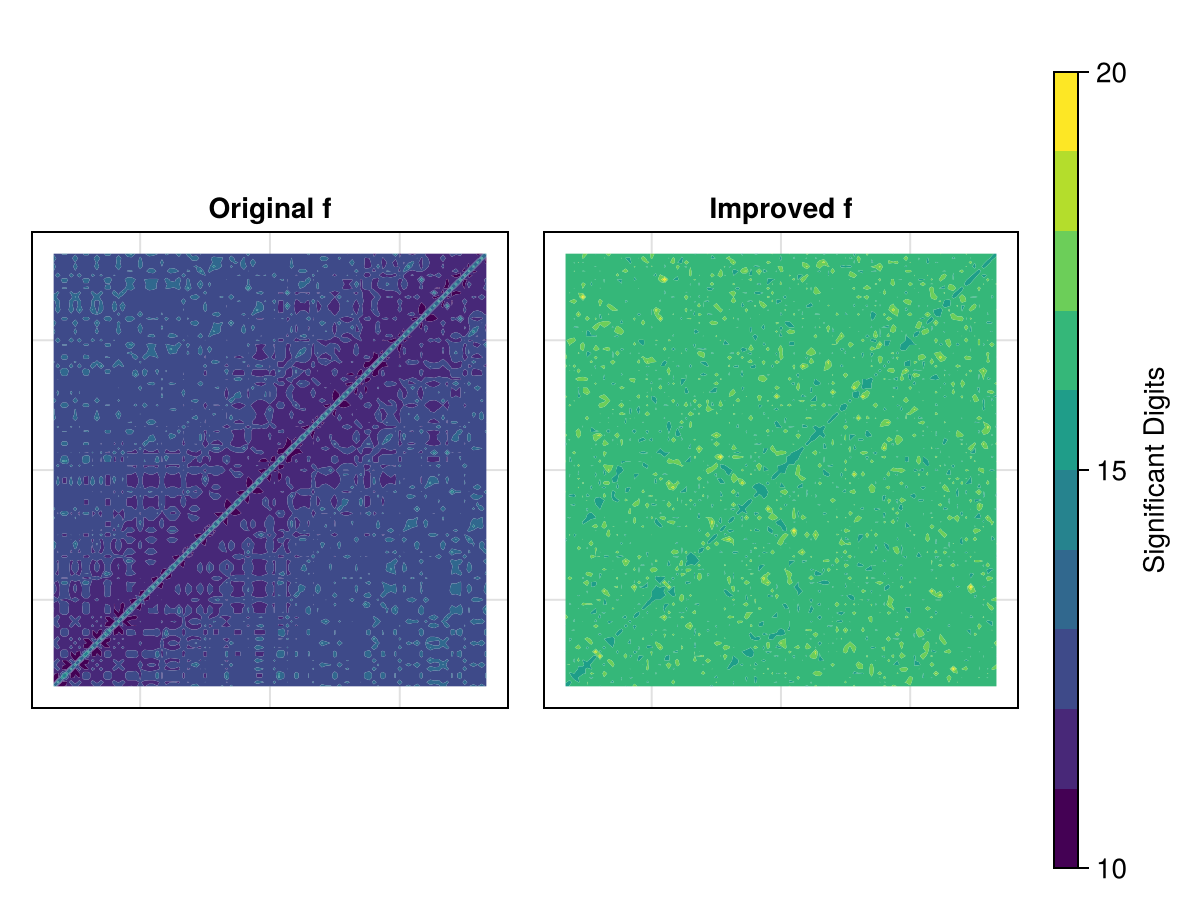

In [11]:
fig = Figure()

z1 = [significant_digits(f(precify(xi), precify(yi))) for yi in y, xi in x]
z2 = [significant_digits(f_improved(precify(xi), precify(yi))) for yi in y, xi in x]

zmin = floor(Int, min(minimum(z1), minimum(z2)))
zmax = ceil(Int, max(maximum(z1), maximum(z2)))

ax1 = Axis(fig[1, 1]; aspect = AxisAspect(1), title = "Original f", xticksvisible = false, yticksvisible = false, xticklabelsvisible = false, yticklabelsvisible = false)
ax2 = Axis(fig[1, 2]; aspect = AxisAspect(1), title = "Improved f", xticksvisible = false, yticksvisible = false, xticklabelsvisible = false, yticklabelsvisible = false)

contour1 = contourf!(ax1, x, y, z1; levels = range(zmin, zmax))
contour2 = contourf!(ax2, x, y, z2; levels = range(zmin, zmax))

Colorbar(fig[1, 3], contour1; label = "Significant Digits")

fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*